# Event-Based Portfolio Backtesting System

**Strategy:** Trend Following with Event-Driven Architecture  
**Universe:** S&P 500 (SPY) Constituent Stocks  
**Period:** January 2010 - December 2019  
**Initial Capital:** $500,000 USD  
**Transaction Cost:** 0%  
**Leverage:** 0x  

---

## 1. Setup and Imports

In [ ]:
# Install required packages
%pip install pandas numpy yfinance matplotlib seaborn ta scipy tqdm -q

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator, ADXIndicator
from ta.volatility import AverageTrueRange
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass, field
from enum import Enum
from datetime import datetime, timedelta
import warnings
from tqdm.notebook import tqdm
import json

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

print("✅ All imports successful!")

✅ All imports successful!


## 2. Configuration and Data Classes

In [3]:
@dataclass
class StrategyConfig:
    """Strategy configuration parameters"""
    # Technical indicator parameters
    ema_fast: int = 20
    ema_slow: int = 50
    rsi_period: int = 14
    adx_period: int = 14
    atr_period: int = 14
    
    # Signal thresholds
    adx_threshold: float = 25.0
    rsi_long_threshold: float = 50.0
    rsi_short_threshold: float = 50.0
    
    # Risk management
    stop_loss_pct: float = 0.02  # 2%
    trailing_stop_pct: float = 0.015  # 1.5%
    max_portfolio_drawdown: float = 0.15  # 15%
    risk_per_trade: float = 0.02  # 2%
    min_position_size: float = 0.1  # 10%
    max_position_size: float = 0.2  # 20% per stock (for portfolio)
    
    # Portfolio parameters
    initial_capital: float = 500000.0  # $500K
    transaction_cost: float = 0.0  # 0%
    leverage: float = 0.0  # No leverage
    max_positions: int = 10  # Max concurrent positions
    
    # Data parameters
    train_start: str = "2010-01-01"
    train_end: str = "2019-12-31"


class EventType(Enum):
    """Types of market events"""
    GOLDEN_CROSS = "golden_cross"
    DEATH_CROSS = "death_cross"
    RSI_OVERBOUGHT = "rsi_overbought"
    RSI_OVERSOLD = "rsi_oversold"
    RSI_EXIT_OVERBOUGHT = "rsi_exit_overbought"
    RSI_EXIT_OVERSOLD = "rsi_exit_oversold"
    STOP_LOSS_HIT = "stop_loss_hit"
    TRAILING_STOP_HIT = "trailing_stop_hit"
    MAX_DRAWDOWN_HIT = "max_drawdown_hit"
    ADX_STRONG_TREND = "adx_strong_trend"
    ADX_WEAK_TREND = "adx_weak_trend"
    ORDER_FILLED = "order_filled"


@dataclass
class Event:
    """Represents a market event"""
    timestamp: datetime
    event_type: EventType
    symbol: str
    data: Dict
    priority: int = 0
    
    def __repr__(self):
        return f"Event({self.timestamp.date()}, {self.symbol}, {self.event_type.value}, priority={self.priority})"


@dataclass
class Position:
    """Represents an open position"""
    symbol: str
    side: str  # 'LONG' or 'SHORT'
    entry_price: float
    entry_time: datetime
    shares: float
    stop_loss: float
    trailing_stop: float
    highest_price: float = 0.0
    lowest_price: float = float('inf')
    
    @property
    def value(self) -> float:
        """Current position value"""
        return self.shares * self.entry_price


@dataclass
class Trade:
    """Completed trade record"""
    symbol: str
    side: str
    entry_time: datetime
    exit_time: datetime
    entry_price: float
    exit_price: float
    shares: float
    pnl: float
    pnl_pct: float
    reason: str


print("✅ Configuration and data classes defined!")

✅ Configuration and data classes defined!


## 3. Get SPY Constituent Stocks

In [4]:
def get_spy_stocks(top_n: int = 50) -> List[str]:
    """
    Get SPY constituent stocks
    For this example, we'll use the top 50 most liquid S&P 500 stocks
    """
    # Top 50 S&P 500 stocks by market cap (as of 2010-2019 period)
    spy_stocks = [
        'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'BRK.B', 'JNJ', 'JPM', 'V', 'PG', 'XOM',
        'BAC', 'MA', 'T', 'DIS', 'HD', 'INTC', 'VZ', 'PFE', 'MRK', 'CSCO',
        'KO', 'PEP', 'WFC', 'CMCSA', 'C', 'CVX', 'NFLX', 'ABT', 'ORCL', 'COST',
        'BA', 'MCD', 'IBM', 'UNH', 'PM', 'GE', 'HON', 'QCOM', 'AMGN', 'MDT',
        'UPS', 'BMY', 'SBUX', 'TXN', 'LOW', 'MMM', 'LMT', 'CAT', 'NKE', 'GS'
    ]
    return spy_stocks[:top_n]

SPY_STOCKS = get_spy_stocks(50)
print(f"✅ Using {len(SPY_STOCKS)} SPY stocks:")
print(f"   {', '.join(SPY_STOCKS[:10])}...")

✅ Using 50 SPY stocks:
   AAPL, MSFT, AMZN, GOOGL, BRK.B, JNJ, JPM, V, PG, XOM...


## 4. Technical Indicators

In [5]:
def calculate_indicators(df: pd.DataFrame, config: StrategyConfig) -> pd.DataFrame:
    """Calculate technical indicators for a stock"""
    data = pd.DataFrame(index=df.index)
    data['Close'] = df['Close']
    data['High'] = df['High']
    data['Low'] = df['Low']
    data['Volume'] = df['Volume']
    
    # EMAs
    data['EMA_Fast'] = EMAIndicator(df['Close'], window=config.ema_fast, fillna=True).ema_indicator()
    data['EMA_Slow'] = EMAIndicator(df['Close'], window=config.ema_slow, fillna=True).ema_indicator()
    
    # RSI
    data['RSI'] = RSIIndicator(df['Close'], window=config.rsi_period, fillna=True).rsi()
    
    # ADX
    adx = ADXIndicator(df['High'], df['Low'], df['Close'], window=config.adx_period, fillna=True)
    data['ADX'] = adx.adx()
    
    # ATR
    atr = AverageTrueRange(df['High'], df['Low'], df['Close'], window=config.atr_period, fillna=True)
    data['ATR'] = atr.average_true_range()
    data['ATR_Pct'] = data['ATR'] / data['Close']
    
    # Drop initial NaN rows
    max_window = max(config.ema_slow, config.adx_period, config.rsi_period)
    data = data.iloc[max_window:]
    
    return data

print("✅ Technical indicators function defined!")

✅ Technical indicators function defined!


## 5. Event Detector

In [6]:
class EventDetector:
    """Detects market events from price data"""
    
    def __init__(self, config: StrategyConfig):
        self.config = config
        self.previous_state = {}
        
    def detect_events(self, symbol: str, current_data: pd.Series, prev_data: Optional[pd.Series]) -> List[Event]:
        """Detect all events for a symbol at current timestamp"""
        events = []
        
        if prev_data is None:
            return events
        
        timestamp = current_data.name
        
        # CROSSOVER EVENTS
        if (current_data['EMA_Fast'] > current_data['EMA_Slow'] and 
            prev_data['EMA_Fast'] <= prev_data['EMA_Slow']):
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.GOLDEN_CROSS,
                symbol=symbol,
                data={'price': current_data['Close'], 'rsi': current_data['RSI'], 'adx': current_data['ADX']},
                priority=10
            ))
        
        if (current_data['EMA_Fast'] < current_data['EMA_Slow'] and 
            prev_data['EMA_Fast'] >= prev_data['EMA_Slow']):
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.DEATH_CROSS,
                symbol=symbol,
                data={'price': current_data['Close'], 'rsi': current_data['RSI'], 'adx': current_data['ADX']},
                priority=10
            ))
        
        # RSI EVENTS
        if current_data['RSI'] > 70 and prev_data['RSI'] <= 70:
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.RSI_OVERBOUGHT,
                symbol=symbol,
                data={'rsi': current_data['RSI'], 'price': current_data['Close']},
                priority=7
            ))
        
        if current_data['RSI'] < 30 and prev_data['RSI'] >= 30:
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.RSI_OVERSOLD,
                symbol=symbol,
                data={'rsi': current_data['RSI'], 'price': current_data['Close']},
                priority=7
            ))
        
        # ADX EVENTS
        if current_data['ADX'] > self.config.adx_threshold and prev_data['ADX'] <= self.config.adx_threshold:
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.ADX_STRONG_TREND,
                symbol=symbol,
                data={'adx': current_data['ADX'], 'price': current_data['Close']},
                priority=6
            ))
        
        return events

print("✅ Event detector class defined!")

✅ Event detector class defined!


## 6. Portfolio Event-Driven Backtester

In [7]:
class PortfolioBacktester:
    """
    Event-driven portfolio backtester
    Tracks daily capital changes and generates performance metrics
    """
    
    def __init__(self, config: StrategyConfig, stock_data: Dict[str, pd.DataFrame]):
        self.config = config
        self.stock_data = stock_data
        self.symbols = list(stock_data.keys())
        
        # Portfolio state
        self.capital = config.initial_capital
        self.initial_capital = config.initial_capital
        self.positions: Dict[str, Position] = {}
        self.trades: List[Trade] = []
        self.event_log: List[Event] = []
        
        # Daily tracking
        self.daily_capital: List[Dict] = []
        self.daily_positions: List[Dict] = []
        
        # Event detection
        self.event_detector = EventDetector(config)
        self.previous_data: Dict[str, pd.Series] = {}
        
        # Get all unique dates
        all_dates = set()
        for df in stock_data.values():
            all_dates.update(df.index)
        self.trading_dates = sorted(list(all_dates))
    
    def calculate_position_size(self, symbol: str, price: float, atr_pct: float) -> float:
        """Calculate number of shares to buy based on risk"""
        # Available capital (considering max positions)
        available_capital = self.capital * self.config.max_position_size
        
        # Position sizing based on ATR
        if atr_pct > 0:
            size_multiplier = self.config.risk_per_trade / atr_pct
            size_multiplier = min(size_multiplier, self.config.max_position_size)
            size_multiplier = max(size_multiplier, self.config.min_position_size)
        else:
            size_multiplier = self.config.min_position_size
        
        # Calculate shares
        position_capital = available_capital * size_multiplier
        shares = position_capital / price
        
        # Apply leverage (currently 0)
        shares *= (1 + self.config.leverage)
        
        return shares
    
    def can_open_position(self) -> bool:
        """Check if we can open a new position"""
        return len(self.positions) < self.config.max_positions
    
    def open_position(self, symbol: str, price: float, timestamp: datetime, atr_pct: float):
        """Open a new long position"""
        shares = self.calculate_position_size(symbol, price, atr_pct)
        position_cost = shares * price
        
        # Apply transaction costs
        transaction_fee = position_cost * self.config.transaction_cost
        total_cost = position_cost + transaction_fee
        
        if total_cost > self.capital:
            return  # Not enough capital
        
        self.capital -= total_cost
        
        position = Position(
            symbol=symbol,
            side='LONG',
            entry_price=price,
            entry_time=timestamp,
            shares=shares,
            stop_loss=price * (1 - self.config.stop_loss_pct),
            trailing_stop=price * (1 - self.config.trailing_stop_pct),
            highest_price=price
        )
        
        self.positions[symbol] = position
    
    def close_position(self, symbol: str, price: float, timestamp: datetime, reason: str):
        """Close an existing position"""
        if symbol not in self.positions:
            return
        
        position = self.positions[symbol]
        position_value = position.shares * price
        
        # Apply transaction costs
        transaction_fee = position_value * self.config.transaction_cost
        proceeds = position_value - transaction_fee
        
        self.capital += proceeds
        
        # Calculate P&L
        pnl = proceeds - (position.shares * position.entry_price)
        pnl_pct = (price - position.entry_price) / position.entry_price
        
        # Record trade
        trade = Trade(
            symbol=symbol,
            side=position.side,
            entry_time=position.entry_time,
            exit_time=timestamp,
            entry_price=position.entry_price,
            exit_price=price,
            shares=position.shares,
            pnl=pnl,
            pnl_pct=pnl_pct,
            reason=reason
        )
        self.trades.append(trade)
        
        del self.positions[symbol]
    
    def check_stops(self, symbol: str, current_price: float, timestamp: datetime):
        """Check if stops are hit for a position"""
        if symbol not in self.positions:
            return
        
        position = self.positions[symbol]
        
        # Update highest price and trailing stop
        if current_price > position.highest_price:
            position.highest_price = current_price
            position.trailing_stop = current_price * (1 - self.config.trailing_stop_pct)
        
        # Check stop loss
        if current_price <= position.stop_loss:
            self.close_position(symbol, current_price, timestamp, "Stop Loss")
        # Check trailing stop
        elif current_price <= position.trailing_stop:
            self.close_position(symbol, current_price, timestamp, "Trailing Stop")
    
    def handle_event(self, event: Event):
        """Handle a market event"""
        self.event_log.append(event)
        
        symbol = event.symbol
        
        # GOLDEN CROSS - Enter long if conditions met
        if event.event_type == EventType.GOLDEN_CROSS:
            if (self.can_open_position() and 
                symbol not in self.positions and
                event.data['rsi'] > self.config.rsi_long_threshold and
                event.data['adx'] > self.config.adx_threshold):
                
                current_data = self.stock_data[symbol].loc[event.timestamp]
                self.open_position(symbol, event.data['price'], event.timestamp, current_data['ATR_Pct'])
        
        # DEATH CROSS - Exit long if exists
        elif event.event_type == EventType.DEATH_CROSS:
            if symbol in self.positions:
                self.close_position(symbol, event.data['price'], event.timestamp, "Death Cross")
    
    def calculate_portfolio_value(self, date: datetime) -> float:
        """Calculate total portfolio value on a given date"""
        total_value = self.capital
        
        for symbol, position in self.positions.items():
            if date in self.stock_data[symbol].index:
                current_price = self.stock_data[symbol].loc[date, 'Close']
                position_value = position.shares * current_price
                total_value += position_value
        
        return total_value
    
    def run(self):
        """Run the backtest"""
        print(f"\n{'='*60}")
        print("EVENT-DRIVEN PORTFOLIO BACKTEST")
        print(f"{'='*60}")
        print(f"Period: {self.config.train_start} to {self.config.train_end}")
        print(f"Universe: {len(self.symbols)} stocks")
        print(f"Initial Capital: ${self.initial_capital:,.0f}")
        print(f"{'='*60}\n")
        
        # Process each trading day
        for date in tqdm(self.trading_dates, desc="Processing days"):
            # Collect events for this day
            day_events = []
            
            for symbol in self.symbols:
                if date not in self.stock_data[symbol].index:
                    continue
                
                current_data = self.stock_data[symbol].loc[date]
                prev_data = self.previous_data.get(symbol)
                
                # Detect events
                events = self.event_detector.detect_events(symbol, current_data, prev_data)
                day_events.extend(events)
                
                # Check stops
                self.check_stops(symbol, current_data['Close'], date)
                
                # Update previous data
                self.previous_data[symbol] = current_data
            
            # Sort events by priority
            day_events.sort(key=lambda e: e.priority, reverse=True)
            
            # Handle all events
            for event in day_events:
                self.handle_event(event)
            
            # Calculate daily portfolio value
            portfolio_value = self.calculate_portfolio_value(date)
            
            self.daily_capital.append({
                'date': date,
                'capital': self.capital,
                'portfolio_value': portfolio_value,
                'num_positions': len(self.positions),
                'invested': portfolio_value - self.capital
            })
        
        print(f"\n{'='*60}")
        print("BACKTEST COMPLETE")
        print(f"{'='*60}")
        print(f"Total Events: {len(self.event_log)}")
        print(f"Total Trades: {len(self.trades)}")
        print(f"Final Portfolio Value: ${portfolio_value:,.2f}")
        print(f"Total Return: {(portfolio_value / self.initial_capital - 1) * 100:.2f}%")
        print(f"{'='*60}\n")

print("✅ Portfolio backtester class defined!")

✅ Portfolio backtester class defined!


## 7. Performance Metrics Calculator

In [8]:
def calculate_portfolio_metrics(backtester: PortfolioBacktester) -> Dict:
    """Calculate comprehensive portfolio performance metrics"""
    
    # Convert to DataFrame
    df = pd.DataFrame(backtester.daily_capital)
    df.set_index('date', inplace=True)
    
    # Calculate returns
    df['daily_return'] = df['portfolio_value'].pct_change()
    df['cumulative_return'] = (df['portfolio_value'] / backtester.initial_capital) - 1
    
    # Drawdown
    df['peak'] = df['portfolio_value'].cummax()
    df['drawdown'] = (df['portfolio_value'] - df['peak']) / df['peak']
    
    # Metrics
    total_return = (df['portfolio_value'].iloc[-1] / backtester.initial_capital) - 1
    
    n_days = len(df)
    n_years = n_days / 252
    annualized_return = (1 + total_return) ** (1 / n_years) - 1
    
    daily_vol = df['daily_return'].std()
    annualized_vol = daily_vol * np.sqrt(252)
    
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0
    
    # Sortino ratio
    downside_returns = df['daily_return'][df['daily_return'] < 0]
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino_ratio = annualized_return / downside_std if downside_std > 0 else 0
    
    max_drawdown = df['drawdown'].min()
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Trade statistics
    trades_df = pd.DataFrame([{
        'symbol': t.symbol,
        'pnl': t.pnl,
        'pnl_pct': t.pnl_pct,
        'reason': t.reason
    } for t in backtester.trades])
    
    if len(trades_df) > 0:
        win_rate = (trades_df['pnl'] > 0).sum() / len(trades_df)
        avg_win = trades_df[trades_df['pnl'] > 0]['pnl_pct'].mean() if (trades_df['pnl'] > 0).any() else 0
        avg_loss = trades_df[trades_df['pnl'] < 0]['pnl_pct'].mean() if (trades_df['pnl'] < 0).any() else 0
        profit_factor = abs(trades_df[trades_df['pnl'] > 0]['pnl'].sum() / trades_df[trades_df['pnl'] < 0]['pnl'].sum()) if (trades_df['pnl'] < 0).any() else 0
    else:
        win_rate = 0
        avg_win = 0
        avg_loss = 0
        profit_factor = 0
    
    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_vol,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio,
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'profit_factor': profit_factor,
        'total_trades': len(backtester.trades),
        'total_events': len(backtester.event_log),
        'final_value': df['portfolio_value'].iloc[-1],
        'daily_data': df
    }

print("✅ Performance metrics calculator defined!")

✅ Performance metrics calculator defined!


## 8. Visualization Functions

In [9]:
def plot_portfolio_performance(metrics: Dict):
    """Plot comprehensive portfolio performance"""
    
    df = metrics['daily_data']
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # 1. Portfolio Value
    axes[0].plot(df.index, df['portfolio_value'], label='Portfolio Value', color='green', linewidth=2)
    axes[0].axhline(y=df['portfolio_value'].iloc[0], color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
    axes[0].set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Portfolio Value ($)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    
    # 2. Drawdown
    axes[1].fill_between(df.index, 0, df['drawdown'] * 100, color='red', alpha=0.3)
    axes[1].axhline(y=-15, color='darkred', linestyle='--', linewidth=2, label='15% Kill Switch')
    axes[1].set_title('Portfolio Drawdown', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Drawdown (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. Number of Positions
    axes[2].plot(df.index, df['num_positions'], label='Active Positions', color='purple', linewidth=2)
    axes[2].fill_between(df.index, 0, df['num_positions'], alpha=0.3, color='purple')
    axes[2].set_title('Number of Active Positions', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Positions')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_performance_summary(metrics: Dict):
    """Print formatted performance summary"""
    
    print(f"\n{'='*60}")
    print("PORTFOLIO PERFORMANCE SUMMARY")
    print(f"{'='*60}\n")
    
    print("Returns:")
    print(f"  Total Return.................. {metrics['total_return']*100:>10.2f}%")
    print(f"  Annualized Return............. {metrics['annualized_return']*100:>10.2f}%")
    print(f"  Final Portfolio Value......... ${metrics['final_value']:>10,.0f}")
    
    print(f"\nRisk Metrics:")
    print(f"  Annualized Volatility......... {metrics['annualized_volatility']*100:>10.2f}%")
    print(f"  Maximum Drawdown.............. {metrics['max_drawdown']*100:>10.2f}%")
    
    print(f"\nRisk-Adjusted Returns:")
    print(f"  Sharpe Ratio.................. {metrics['sharpe_ratio']:>10.2f}")
    print(f"  Sortino Ratio................. {metrics['sortino_ratio']:>10.2f}")
    print(f"  Calmar Ratio.................. {metrics['calmar_ratio']:>10.2f}")
    
    print(f"\nTrading Statistics:")
    print(f"  Total Trades.................. {metrics['total_trades']:>10}")
    print(f"  Total Events.................. {metrics['total_events']:>10}")
    print(f"  Win Rate...................... {metrics['win_rate']*100:>10.2f}%")
    print(f"  Profit Factor................. {metrics['profit_factor']:>10.2f}")
    print(f"  Avg Win....................... {metrics['avg_win']*100:>10.2f}%")
    print(f"  Avg Loss...................... {metrics['avg_loss']*100:>10.2f}%")
    
    print(f"\n{'='*60}\n")

print("✅ Visualization functions defined!")

✅ Visualization functions defined!


## 9. Main Backtest Function

In [10]:
def run_backtest(start_date: str, 
                 end_date: str, 
                 stock_list: List[str],
                 initial_capital: float = 500000.0,
                 transaction_cost: float = 0.0,
                 leverage: float = 0.0,
                 **other_params) -> Dict:
    """
    Run complete backtest on portfolio of stocks
    
    Args:
        start_date: Start date (YYYY-MM-DD)
        end_date: End date (YYYY-MM-DD)
        stock_list: List of stock symbols
        initial_capital: Starting capital
        transaction_cost: Transaction cost as decimal (0 = 0%)
        leverage: Leverage multiplier (0 = no leverage)
        **other_params: Additional strategy parameters
    
    Returns:
        Dictionary with results and metrics
    """
    
    print(f"\n{'='*60}")
    print("DOWNLOADING DATA")
    print(f"{'='*60}")
    print(f"Period: {start_date} to {end_date}")
    print(f"Stocks: {len(stock_list)} symbols")
    
    # Download data for all stocks
    stock_data = {}
    config = StrategyConfig(
        train_start=start_date,
        train_end=end_date,
        initial_capital=initial_capital,
        transaction_cost=transaction_cost,
        leverage=leverage,
        **other_params
    )
    
    for symbol in tqdm(stock_list, desc="Downloading"):
        try:
            ticker = yf.Ticker(symbol)
            df = ticker.history(start=start_date, end=end_date)
            
            if len(df) < 100:  # Skip if insufficient data
                continue
            
            # Calculate indicators
            df_with_indicators = calculate_indicators(df, config)
            stock_data[symbol] = df_with_indicators
            
        except Exception as e:
            print(f"  ⚠️  Failed to download {symbol}: {e}")
            continue
    
    print(f"\n✅ Successfully loaded {len(stock_data)} stocks\n")
    
    # Run backtest
    backtester = PortfolioBacktester(config, stock_data)
    backtester.run()
    
    # Calculate metrics
    metrics = calculate_portfolio_metrics(backtester)
    
    # Visualize
    plot_portfolio_performance(metrics)
    print_performance_summary(metrics)
    
    return {
        'metrics': metrics,
        'backtester': backtester,
        'config': config,
        'daily_capital': backtester.daily_capital,
        'trades': backtester.trades
    }

print("✅ Main backtest function defined!")

✅ Main backtest function defined!


## 10. FINAL NOTEBOOK CELL
---


DOWNLOADING DATA
Period: 2010-01-01 to 2019-12-31
Stocks: 50 symbols


Downloading:   0%|          | 0/50 [00:00<?, ?it/s]

$BRK.B: possibly delisted; no timezone found



✅ Successfully loaded 49 stocks


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 49 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 8143
Total Trades: 138
Final Portfolio Value: $516,734.84
Total Return: 3.35%



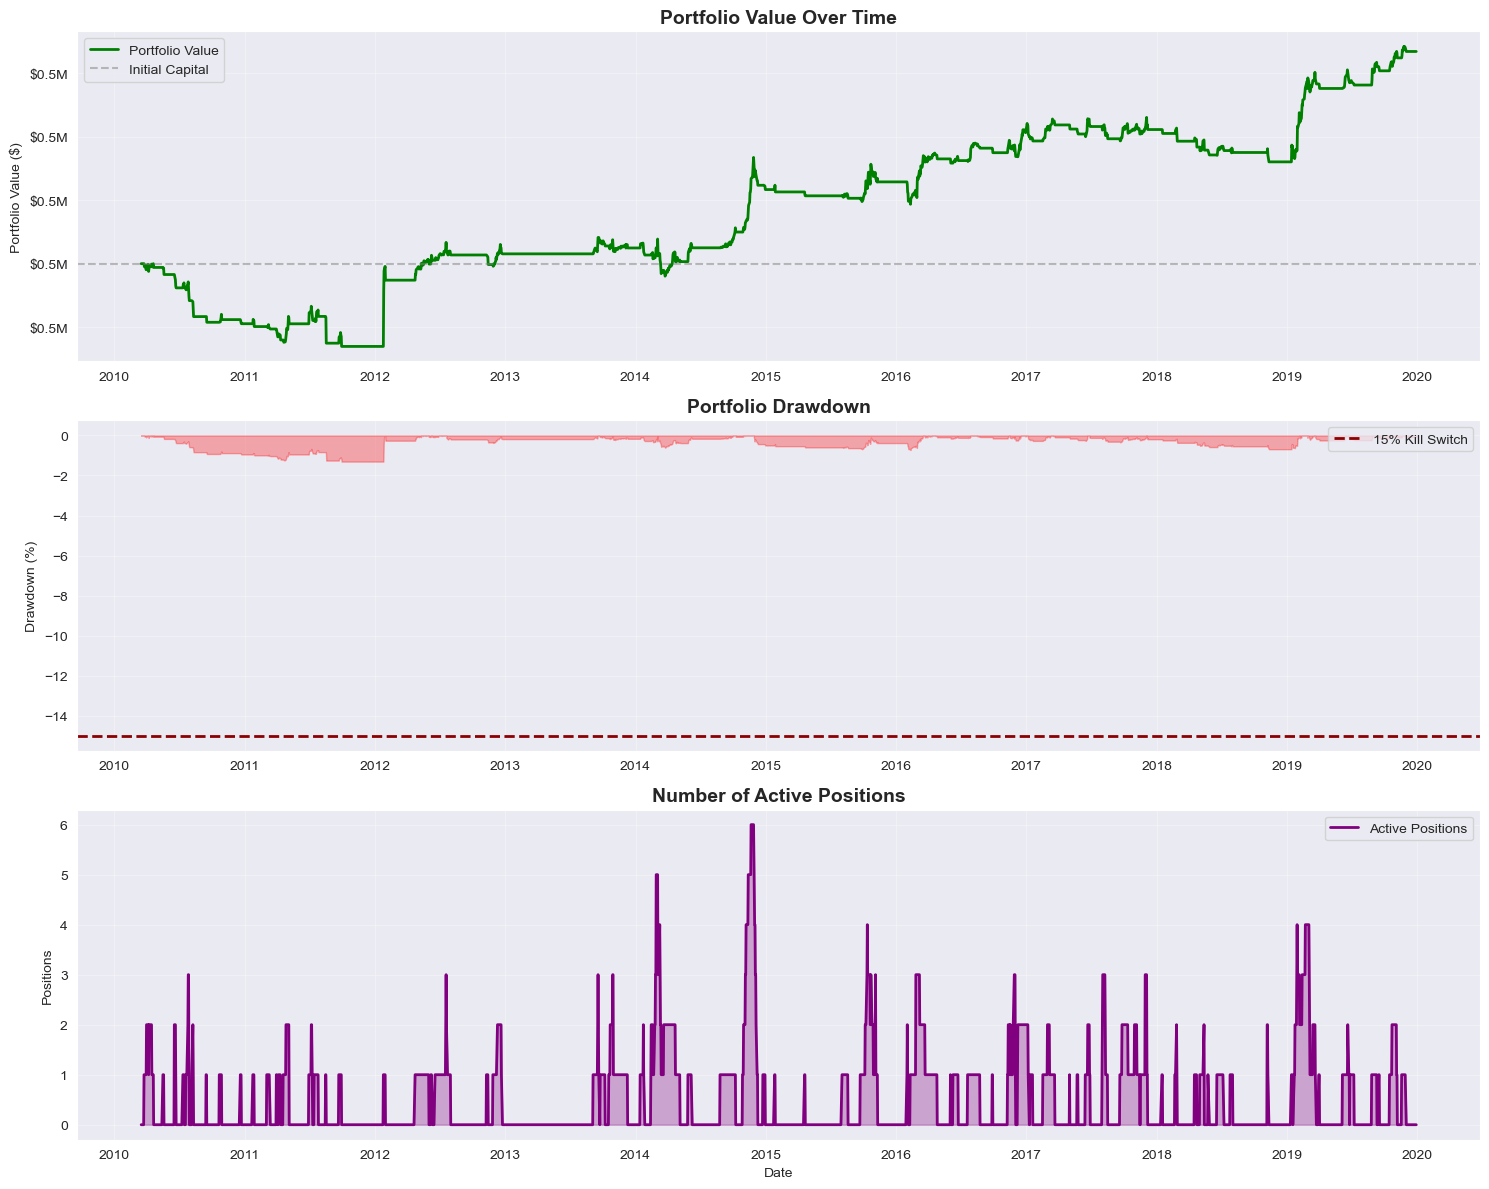


PORTFOLIO PERFORMANCE SUMMARY

Returns:
  Total Return..................       3.35%
  Annualized Return.............       0.34%
  Final Portfolio Value......... $   516,735

Risk Metrics:
  Annualized Volatility.........       0.62%
  Maximum Drawdown..............      -1.31%

Risk-Adjusted Returns:
  Sharpe Ratio..................       0.54
  Sortino Ratio.................       0.48
  Calmar Ratio..................       0.26

Trading Statistics:
  Total Trades..................        138
  Total Events..................       8143
  Win Rate......................      45.65%
  Profit Factor.................       1.60
  Avg Win.......................       3.60%
  Avg Loss......................      -1.92%


{'metrics': {'total_return': 0.03346967704207793, 'annualized_return': 0.0033713023226962235, 'annualized_volatility': 0.006231413909969787, 'sharpe_ratio': 0.541017234836928, 'sortino_ratio': 0.4836251665940693, 'max_drawdown': -0.01305446625749542, 'calmar_ratio': 0.2582

In [11]:
# ============================================================================
# FINAL NOTEBOOK CELL
# ============================================================================

# Define parameters for the backtest
start_date = "2010-01-01"  # We will change this
end_date = "2019-12-31"    # We will change this
stock_list = SPY_STOCKS    # We will also change this

# Other parameters
other_variables = {
    'initial_capital': 500000.0,
    'transaction_cost': 0.0,
    'leverage': 0.0,
    'max_positions': 10,
    'max_position_size': 0.2,
    'stop_loss_pct': 0.02,
    'trailing_stop_pct': 0.015,
    'max_portfolio_drawdown': 0.15,
    'risk_per_trade': 0.02
}

# One function that runs the backtest
results = run_backtest(start_date=start_date, 
                       end_date=end_date,
                       stock_list=stock_list,
                       **other_variables)

# Display Results
print(results)

In [12]:
# ============================================================================
# BUY-AND-HOLD BENCHMARK CALCULATOR
# ============================================================================

def calculate_buy_and_hold(stock_list: List[str], 
                          start_date: str, 
                          end_date: str, 
                          initial_capital: float = 500000.0) -> Dict:
    """
    Calculate buy-and-hold returns for equal-weighted portfolio
    
    Strategy: Buy equal amounts of all stocks at start, hold until end
    """
    print(f"\n{'='*60}")
    print("CALCULATING BUY-AND-HOLD BENCHMARK")
    print(f"{'='*60}")
    
    portfolio_data = []
    
    # Download data for all stocks
    for symbol in tqdm(stock_list, desc="Downloading B&H data"):
        try:
            ticker = yf.Ticker(symbol)
            df = ticker.history(start=start_date, end=end_date)
            
            if len(df) < 100:
                continue
            
            portfolio_data.append({
                'symbol': symbol,
                'start_price': df['Close'].iloc[0],
                'end_price': df['Close'].iloc[-1],
                'data': df
            })
            
        except Exception as e:
            continue
    
    # Equal weight allocation
    capital_per_stock = initial_capital / len(portfolio_data)
    
    # Calculate daily portfolio values
    total_value = 0
    daily_values = {}
    
    for stock in portfolio_data:
        shares = capital_per_stock / stock['start_price']
        final_value = shares * stock['end_price']
        total_value += final_value
        
        # Track daily values
        for date, row in stock['data'].iterrows():
            if date not in daily_values:
                daily_values[date] = 0
            daily_values[date] += shares * row['Close']
    
    # Create daily portfolio dataframe
    df_daily = pd.DataFrame([
        {'date': date, 'portfolio_value': value}
        for date, value in sorted(daily_values.items())
    ])
    df_daily.set_index('date', inplace=True)
    
    # Calculate returns
    df_daily['daily_return'] = df_daily['portfolio_value'].pct_change()
    df_daily['cumulative_return'] = (df_daily['portfolio_value'] / initial_capital) - 1
    
    # Drawdown
    df_daily['peak'] = df_daily['portfolio_value'].cummax()
    df_daily['drawdown'] = (df_daily['portfolio_value'] - df_daily['peak']) / df_daily['peak']
    
    # Performance metrics
    total_return = (total_value / initial_capital) - 1
    n_days = len(df_daily)
    n_years = n_days / 252
    annualized_return = (1 + total_return) ** (1 / n_years) - 1
    
    daily_vol = df_daily['daily_return'].std()
    annualized_vol = daily_vol * np.sqrt(252)
    
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0
    
    downside_returns = df_daily['daily_return'][df_daily['daily_return'] < 0]
    downside_std = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0.0001
    sortino_ratio = annualized_return / downside_std if downside_std > 0 else 0
    
    max_drawdown = df_daily['drawdown'].min()
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    print(f"\n✅ Buy-and-Hold calculated for {len(portfolio_data)} stocks")
    print(f"Final Value: ${total_value:,.2f}")
    print(f"Total Return: {total_return*100:.2f}%")
    
    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_vol,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio,
        'final_value': total_value,
        'daily_data': df_daily,
        'num_stocks': len(portfolio_data)
    }

print("✅ Buy-and-Hold benchmark function defined!")

✅ Buy-and-Hold benchmark function defined!


In [14]:
# ============================================================================
# STRATEGY VS BUY-AND-HOLD COMPARISON
# ============================================================================

def compare_strategy_vs_benchmark(strategy_metrics: Dict, 
                                  bh_metrics: Dict,
                                  start_date: str,
                                  end_date: str):
    """
    Compare strategy performance vs buy-and-hold benchmark
    """
    
    # Extract data
    strategy_data = strategy_metrics['daily_data']
    bh_data = bh_metrics['daily_data']
    
    # Create comparison plots
    fig, axes = plt.subplots(3, 2, figsize=(18, 14))
    
    # 1. Portfolio Value Comparison
    axes[0, 0].plot(strategy_data.index, strategy_data['portfolio_value'], 
                    label='Strategy', color='green', linewidth=2)
    axes[0, 0].plot(bh_data.index, bh_data['portfolio_value'], 
                    label='Buy & Hold', color='blue', linewidth=2, alpha=0.7)
    axes[0, 0].axhline(y=strategy_metrics['final_value'], color='green', 
                       linestyle='--', alpha=0.3)
    axes[0, 0].axhline(y=bh_metrics['final_value'], color='blue', 
                       linestyle='--', alpha=0.3)
    axes[0, 0].set_title('Portfolio Value: Strategy vs Buy-and-Hold', 
                         fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Portfolio Value ($)')
    axes[0, 0].legend(loc='best')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    
    # 2. Cumulative Returns Comparison
    axes[0, 1].plot(strategy_data.index, strategy_data['cumulative_return'] * 100, 
                    label='Strategy', color='green', linewidth=2)
    axes[0, 1].plot(bh_data.index, bh_data['cumulative_return'] * 100, 
                    label='Buy & Hold', color='blue', linewidth=2, alpha=0.7)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[0, 1].set_title('Cumulative Returns Comparison', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Cumulative Return (%)')
    axes[0, 1].legend(loc='best')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Drawdown Comparison
    axes[1, 0].fill_between(strategy_data.index, 0, strategy_data['drawdown'] * 100, 
                            color='green', alpha=0.3, label='Strategy')
    axes[1, 0].fill_between(bh_data.index, 0, bh_data['drawdown'] * 100, 
                            color='blue', alpha=0.3, label='Buy & Hold')
    axes[1, 0].set_title('Drawdown Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Drawdown (%)')
    axes[1, 0].legend(loc='best')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Rolling Sharpe Ratio (252-day window)
    strategy_rolling_sharpe = (strategy_data['daily_return'].rolling(252).mean() * 252) / \
                              (strategy_data['daily_return'].rolling(252).std() * np.sqrt(252))
    bh_rolling_sharpe = (bh_data['daily_return'].rolling(252).mean() * 252) / \
                        (bh_data['daily_return'].rolling(252).std() * np.sqrt(252))
    
    axes[1, 1].plot(strategy_data.index, strategy_rolling_sharpe, 
                    label='Strategy', color='green', linewidth=2)
    axes[1, 1].plot(bh_data.index, bh_rolling_sharpe, 
                    label='Buy & Hold', color='blue', linewidth=2, alpha=0.7)
    axes[1, 1].axhline(y=1.0, color='red', linestyle='--', linewidth=1, label='Sharpe = 1.0')
    axes[1, 1].set_title('Rolling Sharpe Ratio (1-Year)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Sharpe Ratio')
    axes[1, 1].legend(loc='best')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 5. Performance Metrics Bar Chart
    metrics_comparison = {
        'Total Return (%)': [strategy_metrics['total_return'] * 100, 
                            bh_metrics['total_return'] * 100],
        'Ann. Return (%)': [strategy_metrics['annualized_return'] * 100, 
                           bh_metrics['annualized_return'] * 100],
        'Sharpe Ratio': [strategy_metrics['sharpe_ratio'], 
                        bh_metrics['sharpe_ratio']],
        'Sortino Ratio': [strategy_metrics['sortino_ratio'], 
                         bh_metrics['sortino_ratio']],
        'Calmar Ratio': [strategy_metrics['calmar_ratio'], 
                        bh_metrics['calmar_ratio']]
    }
    
    x = np.arange(len(metrics_comparison))
    width = 0.35
    
    strategy_values = [v[0] for v in metrics_comparison.values()]
    bh_values = [v[1] for v in metrics_comparison.values()]
    
    axes[2, 0].bar(x - width/2, strategy_values, width, label='Strategy', color='green', alpha=0.7)
    axes[2, 0].bar(x + width/2, bh_values, width, label='Buy & Hold', color='blue', alpha=0.7)
    axes[2, 0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
    axes[2, 0].set_ylabel('Value')
    axes[2, 0].set_xticks(x)
    axes[2, 0].set_xticklabels(metrics_comparison.keys(), rotation=45, ha='right')
    axes[2, 0].legend(loc='best')
    axes[2, 0].grid(True, alpha=0.3, axis='y')
    axes[2, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # 6. Risk Metrics Bar Chart
    risk_comparison = {
        'Ann. Vol (%)': [strategy_metrics['annualized_volatility'] * 100, 
                        bh_metrics['annualized_volatility'] * 100],
        'Max DD (%)': [strategy_metrics['max_drawdown'] * 100, 
                      bh_metrics['max_drawdown'] * 100]
    }
    
    x_risk = np.arange(len(risk_comparison))
    strategy_risk = [v[0] for v in risk_comparison.values()]
    bh_risk = [v[1] for v in risk_comparison.values()]
    
    axes[2, 1].bar(x_risk - width/2, strategy_risk, width, label='Strategy', color='green', alpha=0.7)
    axes[2, 1].bar(x_risk + width/2, bh_risk, width, label='Buy & Hold', color='blue', alpha=0.7)
    axes[2, 1].set_title('Risk Metrics Comparison (Lower is Better)', fontsize=14, fontweight='bold')
    axes[2, 1].set_ylabel('Value (%)')
    axes[2, 1].set_xticks(x_risk)
    axes[2, 1].set_xticklabels(risk_comparison.keys())
    axes[2, 1].legend(loc='best')
    axes[2, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison table
    print(f"\n{'='*80}")
    print(f"STRATEGY VS BUY-AND-HOLD COMPARISON")
    print(f"Period: {start_date} to {end_date}")
    print(f"{'='*80}\n")
    
    comparison_df = pd.DataFrame({
        'Strategy': {
            'Total Return': f"{strategy_metrics['total_return']*100:.2f}%",
            'Annualized Return': f"{strategy_metrics['annualized_return']*100:.2f}%",
            'Annualized Volatility': f"{strategy_metrics['annualized_volatility']*100:.2f}%",
            'Sharpe Ratio': f"{strategy_metrics['sharpe_ratio']:.2f}",
            'Sortino Ratio': f"{strategy_metrics['sortino_ratio']:.2f}",
            'Max Drawdown': f"{strategy_metrics['max_drawdown']*100:.2f}%",
            'Calmar Ratio': f"{strategy_metrics['calmar_ratio']:.2f}",
            'Final Value': f"${strategy_metrics['final_value']:,.0f}"
        },
        'Buy & Hold': {
            'Total Return': f"{bh_metrics['total_return']*100:.2f}%",
            'Annualized Return': f"{bh_metrics['annualized_return']*100:.2f}%",
            'Annualized Volatility': f"{bh_metrics['annualized_volatility']*100:.2f}%",
            'Sharpe Ratio': f"{bh_metrics['sharpe_ratio']:.2f}",
            'Sortino Ratio': f"{bh_metrics['sortino_ratio']:.2f}",
            'Max Drawdown': f"{bh_metrics['max_drawdown']*100:.2f}%",
            'Calmar Ratio': f"{bh_metrics['calmar_ratio']:.2f}",
            'Final Value': f"${bh_metrics['final_value']:,.0f}"
        }
    })
    
    # Add difference column
    comparison_df['Difference'] = ''
    for metric in comparison_df.index:
        if metric == 'Final Value':
            diff = strategy_metrics['final_value'] - bh_metrics['final_value']
            comparison_df.loc[metric, 'Difference'] = f"${diff:,.0f}"
        elif 'Ratio' in metric:
            diff = strategy_metrics[metric.lower().replace(' ', '_')] - bh_metrics[metric.lower().replace(' ', '_')]
            comparison_df.loc[metric, 'Difference'] = f"{diff:+.2f}"
        else:
            metric_key = metric.lower().replace(' ', '_')
            diff = (strategy_metrics[metric_key] - bh_metrics[metric_key]) * 100
            comparison_df.loc[metric, 'Difference'] = f"{diff:+.2f}%"
    
    print(comparison_df.to_string())
    
    # Determine winner
    print(f"\n{'='*80}")
    print("WINNER DETERMINATION")
    print(f"{'='*80}")
    
    strategy_wins = 0
    bh_wins = 0
    
    if strategy_metrics['total_return'] > bh_metrics['total_return']:
        print("✅ Strategy has HIGHER total return")
        strategy_wins += 1
    else:
        print("❌ Buy & Hold has HIGHER total return")
        bh_wins += 1
    
    if strategy_metrics['sharpe_ratio'] > bh_metrics['sharpe_ratio']:
        print("✅ Strategy has BETTER risk-adjusted returns (Sharpe)")
        strategy_wins += 1
    else:
        print("❌ Buy & Hold has BETTER risk-adjusted returns (Sharpe)")
        bh_wins += 1
    
    if strategy_metrics['max_drawdown'] > bh_metrics['max_drawdown']:
        print("✅ Strategy has LOWER maximum drawdown")
        strategy_wins += 1
    else:
        print("❌ Buy & Hold has LOWER maximum drawdown")
        bh_wins += 1
    
    if strategy_metrics['annualized_volatility'] < bh_metrics['annualized_volatility']:
        print("✅ Strategy has LOWER volatility")
        strategy_wins += 1
    else:
        print("❌ Buy & Hold has LOWER volatility")
        bh_wins += 1
    
    print(f"\n{'='*80}")
    if strategy_wins > bh_wins:
        print(f"🏆 STRATEGY WINS: {strategy_wins} vs {bh_wins}")
        print("✅ Your event-driven strategy OUTPERFORMS buy-and-hold!")
    elif bh_wins > strategy_wins:
        print(f"🏆 BUY & HOLD WINS: {bh_wins} vs {strategy_wins}")
        print("❌ Buy-and-hold strategy OUTPERFORMS your strategy")
    else:
        print(f"🤝 TIE: {strategy_wins} vs {bh_wins}")
        print("⚖️  Both strategies perform equally")
    print(f"{'='*80}\n")

print("✅ Comparison function defined!")

✅ Comparison function defined!



CALCULATING BUY-AND-HOLD BENCHMARK


$BRK.B: possibly delisted; no timezone found



✅ Buy-and-Hold calculated for 49 stocks
Final Value: $2,776,798.87
Total Return: 455.36%


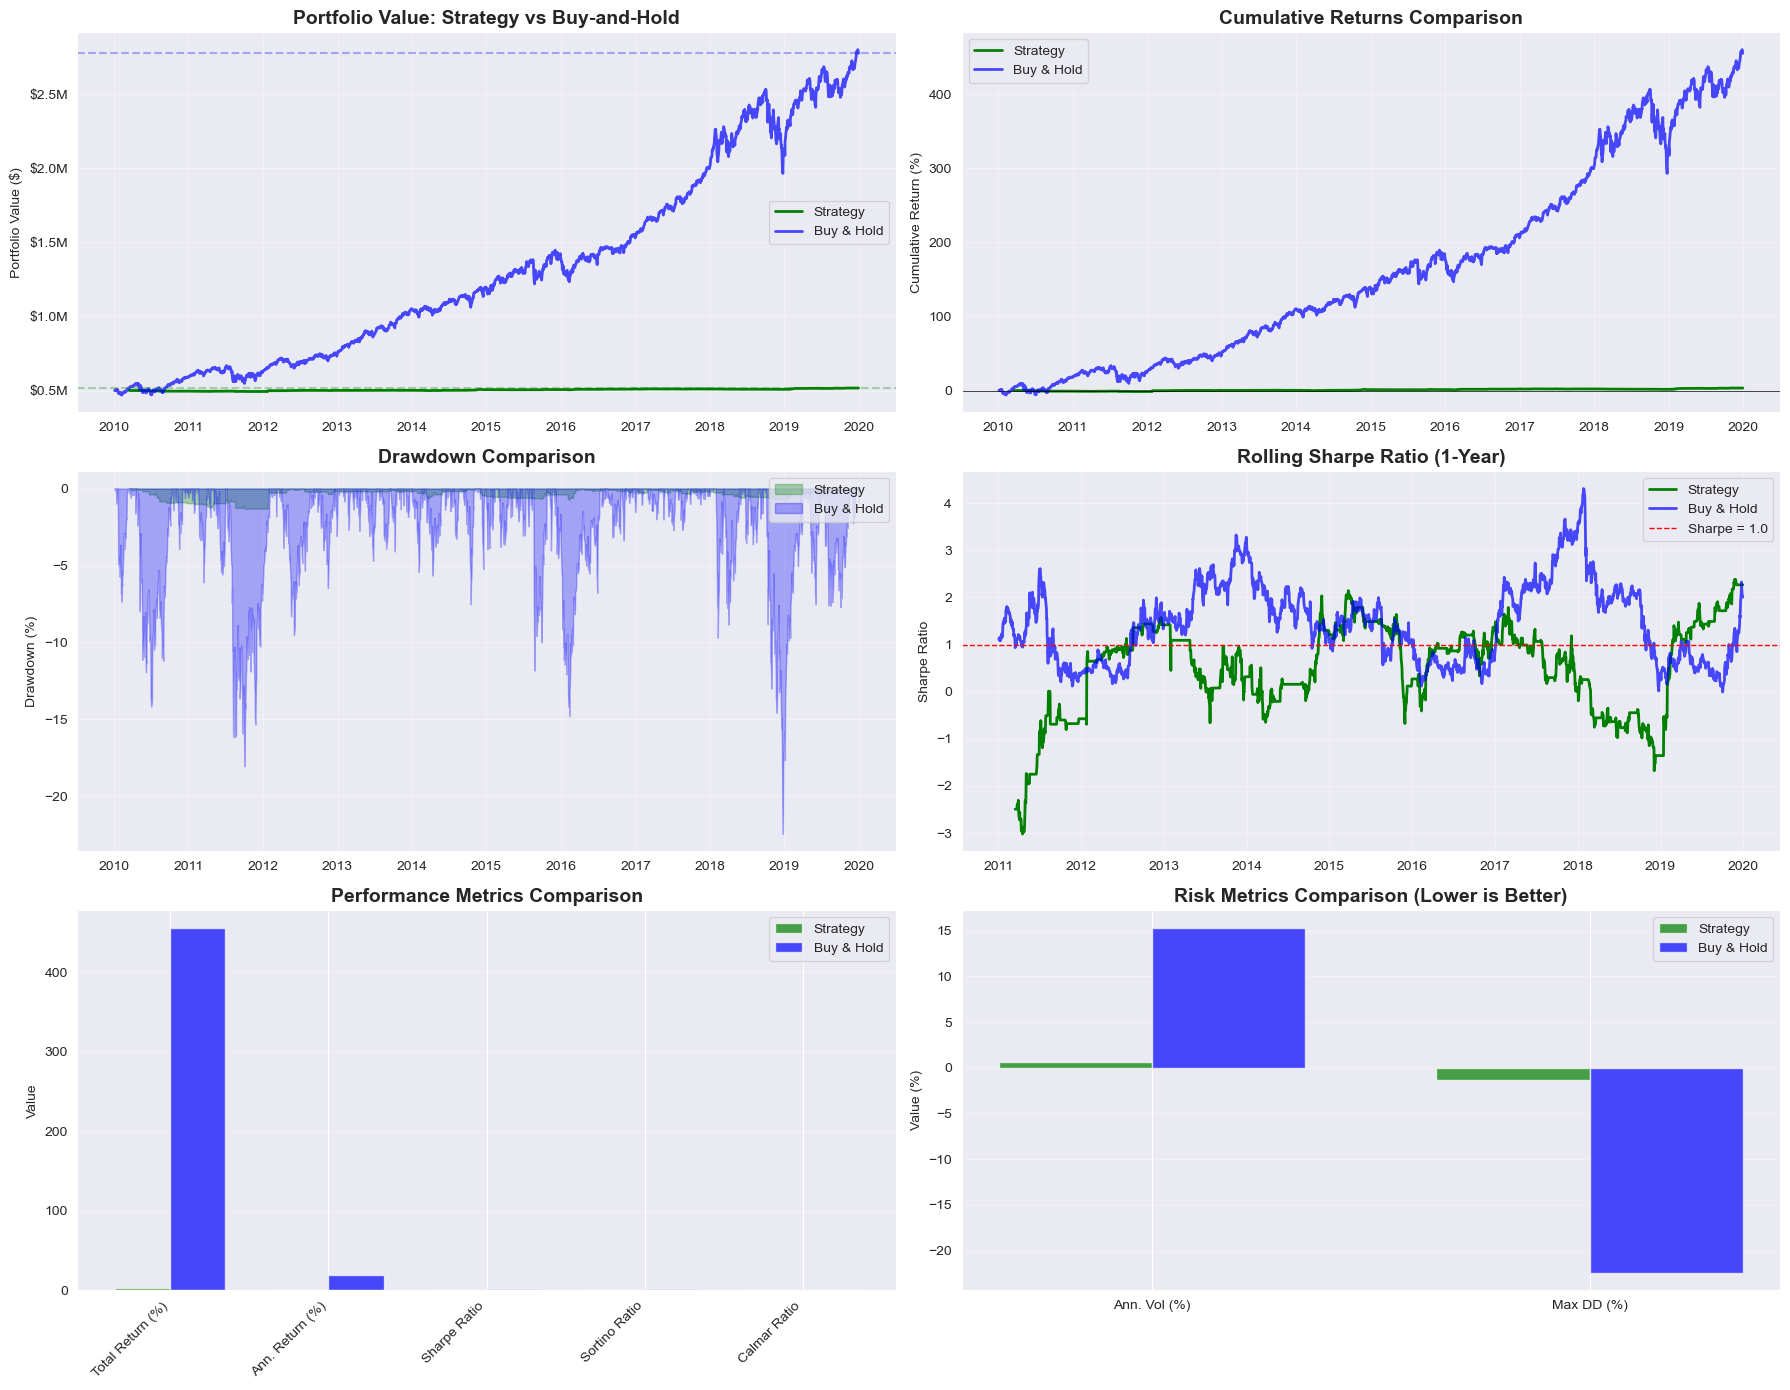


STRATEGY VS BUY-AND-HOLD COMPARISON
Period: 2010-01-01 to 2019-12-31

                       Strategy  Buy & Hold   Difference
Total Return              3.35%     455.36%     -452.01%
Annualized Return         0.34%      18.74%      -18.41%
Annualized Volatility     0.62%      15.33%      -14.70%
Sharpe Ratio               0.54        1.22        -0.68
Sortino Ratio              0.48        1.55        -1.06
Max Drawdown             -1.31%     -22.45%      +21.14%
Calmar Ratio               0.26        0.83        -0.58
Final Value            $516,735  $2,776,799  $-2,260,064

WINNER DETERMINATION
❌ Buy & Hold has HIGHER total return
❌ Buy & Hold has BETTER risk-adjusted returns (Sharpe)
✅ Strategy has LOWER maximum drawdown
✅ Strategy has LOWER volatility

🤝 TIE: 2 vs 2
⚖️  Both strategies perform equally



In [15]:
# ============================================================================
# RUN STRATEGY VS BUY-AND-HOLD COMPARISON
# ============================================================================

# Assuming you have already run your strategy backtest and stored results in 'results'
# If not, run your backtest first:
# results = run_backtest(start_date=start_date, end_date=end_date, stock_list=stock_list, **other_variables)

# Calculate Buy-and-Hold benchmark
bh_results = calculate_buy_and_hold(
    stock_list=stock_list,
    start_date=start_date,
    end_date=end_date,
    initial_capital=other_variables['initial_capital']
)

# Compare Strategy vs Buy-and-Hold
compare_strategy_vs_benchmark(
    strategy_metrics=results['metrics'],
    bh_metrics=bh_results,
    start_date=start_date,
    end_date=end_date
)

In [16]:
#add monte carlo
# ============================================================================
# MONTE CARLO SIMULATION: PARAMETER UNCERTAINTY
# ============================================================================

def monte_carlo_parameter_test(stock_data: Dict[str, pd.DataFrame],
                               base_config: StrategyConfig,
                               n_simulations: int = 500) -> pd.DataFrame:
    """
    Test strategy with random parameter variations
    
    Randomly samples parameters from reasonable ranges to test robustness
    """
    print(f"\n{'='*60}")
    print(f"MONTE CARLO: PARAMETER UNCERTAINTY TEST ({n_simulations} runs)")
    print(f"{'='*60}\n")
    
    # Define parameter ranges
    param_ranges = {
        'ema_fast': list(range(10, 31, 5)),           # [10, 15, 20, 25, 30]
        'ema_slow': list(range(30, 71, 10)),          # [30, 40, 50, 60, 70]
        'rsi_period': list(range(10, 21, 2)),         # [10, 12, 14, 16, 18, 20]
        'adx_threshold': np.arange(15, 36, 5),        # [15, 20, 25, 30, 35]
        'rsi_long_threshold': np.arange(45, 61, 5),   # [45, 50, 55, 60]
        'stop_loss_pct': np.arange(0.015, 0.031, 0.005),     # [1.5%, 2%, 2.5%, 3%]
        'trailing_stop_pct': np.arange(0.01, 0.026, 0.005),  # [1%, 1.5%, 2%, 2.5%]
        'max_positions': list(range(5, 16, 5))        # [5, 10, 15]
    }
    
    results = []
    failed_count = 0
    
    for i in tqdm(range(n_simulations), desc="Running parameter variations"):
        # Random parameter selection
        test_config = StrategyConfig(
            ema_fast=np.random.choice(param_ranges['ema_fast']),
            ema_slow=np.random.choice(param_ranges['ema_slow']),
            rsi_period=np.random.choice(param_ranges['rsi_period']),
            adx_threshold=np.random.choice(param_ranges['adx_threshold']),
            rsi_long_threshold=np.random.choice(param_ranges['rsi_long_threshold']),
            stop_loss_pct=np.random.choice(param_ranges['stop_loss_pct']),
            trailing_stop_pct=np.random.choice(param_ranges['trailing_stop_pct']),
            max_positions=np.random.choice(param_ranges['max_positions']),
            initial_capital=base_config.initial_capital,
            transaction_cost=base_config.transaction_cost,
            leverage=base_config.leverage,
            train_start=base_config.train_start,
            train_end=base_config.train_end
        )
        
        # Ensure fast < slow
        if test_config.ema_fast >= test_config.ema_slow:
            failed_count += 1
            continue
        
        try:
            # Run backtest with new parameters
            backtester = PortfolioBacktester(test_config, stock_data)
            backtester.run()
            
            metrics = calculate_portfolio_metrics(backtester)
            
            results.append({
                'run': i,
                'ema_fast': test_config.ema_fast,
                'ema_slow': test_config.ema_slow,
                'adx_threshold': test_config.adx_threshold,
                'stop_loss_pct': test_config.stop_loss_pct,
                'max_positions': test_config.max_positions,
                'total_return': metrics['total_return'],
                'annualized_return': metrics['annualized_return'],
                'sharpe_ratio': metrics['sharpe_ratio'],
                'sortino_ratio': metrics['sortino_ratio'],
                'max_drawdown': metrics['max_drawdown'],
                'calmar_ratio': metrics['calmar_ratio'],
                'win_rate': metrics['win_rate'],
                'total_trades': metrics['total_trades']
            })
            
        except Exception as e:
            failed_count += 1
            continue
    
    results_df = pd.DataFrame(results)
    
    print(f"\n✅ Completed: {len(results_df)} successful, {failed_count} failed")
    print(f"\nParameter Uncertainty Results:")
    print(f"  Mean Sharpe Ratio: {results_df['sharpe_ratio'].mean():.2f}")
    print(f"  Median Sharpe Ratio: {results_df['sharpe_ratio'].median():.2f}")
    print(f"  Std Dev Sharpe Ratio: {results_df['sharpe_ratio'].std():.2f}")
    print(f"  % Profitable Runs: {(results_df['total_return'] > 0).sum() / len(results_df) * 100:.1f}%")
    print(f"  % Sharpe > 1.0: {(results_df['sharpe_ratio'] > 1.0).sum() / len(results_df) * 100:.1f}%")
    
    return results_df

print("✅ Monte Carlo parameter test function defined!")

✅ Monte Carlo parameter test function defined!


In [17]:
# ============================================================================
# MONTE CARLO SIMULATION: BOOTSTRAP RESAMPLING
# ============================================================================

def monte_carlo_bootstrap_test(strategy_results: pd.DataFrame,
                               n_samples: int = 1000) -> pd.DataFrame:
    """
    Bootstrap resampling of daily returns to test statistical significance
    
    Resamples with replacement to generate confidence intervals
    """
    print(f"\n{'='*60}")
    print(f"MONTE CARLO: BOOTSTRAP RESAMPLING ({n_samples} samples)")
    print(f"{'='*60}\n")
    
    # Get strategy returns
    daily_returns = strategy_results['daily_return'].dropna()
    n_days = len(daily_returns)
    
    if n_days < 10:
        print("⚠️ Insufficient data for bootstrap")
        return pd.DataFrame()
    
    bootstrap_results = []
    
    for i in tqdm(range(n_samples), desc="Bootstrap resampling"):
        # Resample with replacement
        resampled_returns = np.random.choice(daily_returns, size=n_days, replace=True)
        
        # Calculate metrics
        total_return = np.exp(resampled_returns.sum()) - 1
        annual_return = (1 + total_return) ** (252 / n_days) - 1
        annual_vol = resampled_returns.std() * np.sqrt(252)
        sharpe = annual_return / annual_vol if annual_vol > 0 else 0
        
        # Downside deviation
        downside = resampled_returns[resampled_returns < 0]
        downside_std = downside.std() * np.sqrt(252) if len(downside) > 0 else 0.0001
        sortino = annual_return / downside_std if downside_std > 0 else 0
        
        bootstrap_results.append({
            'sample': i,
            'total_return': total_return,
            'annualized_return': annual_return,
            'annualized_volatility': annual_vol,
            'sharpe_ratio': sharpe,
            'sortino_ratio': sortino
        })
    
    bootstrap_df = pd.DataFrame(bootstrap_results)
    
    print(f"\n✅ Bootstrap Resampling Results:")
    print(f"  Mean Return: {bootstrap_df['annualized_return'].mean()*100:.2f}%")
    print(f"  95% CI Return: [{bootstrap_df['annualized_return'].quantile(0.025)*100:.2f}%, "
          f"{bootstrap_df['annualized_return'].quantile(0.975)*100:.2f}%]")
    print(f"  Mean Sharpe: {bootstrap_df['sharpe_ratio'].mean():.2f}")
    print(f"  95% CI Sharpe: [{bootstrap_df['sharpe_ratio'].quantile(0.025):.2f}, "
          f"{bootstrap_df['sharpe_ratio'].quantile(0.975):.2f}]")
    print(f"  Probability of Positive Return: {(bootstrap_df['annualized_return'] > 0).sum() / len(bootstrap_df) * 100:.1f}%")
    
    return bootstrap_df

print("✅ Monte Carlo bootstrap function defined!")

✅ Monte Carlo bootstrap function defined!


In [18]:
# ============================================================================
# MONTE CARLO SIMULATION: SYNTHETIC PRICE PATHS
# ============================================================================

def monte_carlo_synthetic_paths(stock_list: List[str],
                                start_date: str,
                                end_date: str,
                                base_config: StrategyConfig,
                                n_paths: int = 100) -> pd.DataFrame:
    """
    Test strategy on synthetic price paths using Geometric Brownian Motion
    
    Generates random price paths with same statistical properties as real data
    """
    print(f"\n{'='*60}")
    print(f"MONTE CARLO: SYNTHETIC PRICE PATHS ({n_paths} paths)")
    print(f"{'='*60}\n")
    
    # Download real data to estimate parameters
    print("Downloading historical data to estimate parameters...")
    stock_data = {}
    
    for symbol in tqdm(stock_list[:10], desc="Downloading"):  # Use subset for speed
        try:
            ticker = yf.Ticker(symbol)
            df = ticker.history(start=start_date, end=end_date)
            
            if len(df) < 100:
                continue
            
            stock_data[symbol] = df
        except:
            continue
    
    if len(stock_data) == 0:
        print("⚠️ No data available")
        return pd.DataFrame()
    
    # Estimate parameters (mu, sigma) for each stock
    stock_params = {}
    for symbol, df in stock_data.items():
        returns = np.log(df['Close'] / df['Close'].shift(1)).dropna()
        stock_params[symbol] = {
            'mu': returns.mean(),
            'sigma': returns.std(),
            'initial_price': df['Close'].iloc[0],
            'n_days': len(df)
        }
    
    # Run simulations
    synthetic_results = []
    failed_count = 0
    
    for path_num in tqdm(range(n_paths), desc="Generating synthetic paths"):
        # Generate synthetic data for each stock
        synthetic_stock_data = {}
        
        for symbol, params in stock_params.items():
            # Geometric Brownian Motion
            dt = 1/252
            n_days = params['n_days']
            price_path = [params['initial_price']]
            
            for _ in range(n_days - 1):
                drift = (params['mu'] - 0.5 * params['sigma']**2) * dt
                diffusion = params['sigma'] * np.sqrt(dt) * np.random.normal()
                price = price_path[-1] * np.exp(drift + diffusion)
                price_path.append(price)
            
            # Create synthetic dataframe
            dates = pd.date_range(start=start_date, periods=n_days, freq='D')
            synthetic_df = pd.DataFrame({
                'Close': price_path,
                'High': [p * (1 + abs(np.random.normal(0, 0.01))) for p in price_path],
                'Low': [p * (1 - abs(np.random.normal(0, 0.01))) for p in price_path],
                'Volume': [np.random.randint(1000000, 10000000) for _ in price_path]
            }, index=dates)
            
            # Calculate indicators
            try:
                df_with_indicators = calculate_indicators(synthetic_df, base_config)
                synthetic_stock_data[symbol] = df_with_indicators
            except:
                continue
        
        if len(synthetic_stock_data) < 3:
            failed_count += 1
            continue
        
        # Run backtest on synthetic data
        try:
            backtester = PortfolioBacktester(base_config, synthetic_stock_data)
            backtester.run()
            
            metrics = calculate_portfolio_metrics(backtester)
            
            synthetic_results.append({
                'path': path_num,
                'total_return': metrics['total_return'],
                'annualized_return': metrics['annualized_return'],
                'sharpe_ratio': metrics['sharpe_ratio'],
                'sortino_ratio': metrics['sortino_ratio'],
                'max_drawdown': metrics['max_drawdown'],
                'calmar_ratio': metrics['calmar_ratio'],
                'total_trades': metrics['total_trades']
            })
            
        except Exception as e:
            failed_count += 1
            continue
    
    synthetic_df = pd.DataFrame(synthetic_results)
    
    if len(synthetic_df) > 0:
        print(f"\n✅ Completed: {len(synthetic_df)} successful, {failed_count} failed")
        print(f"\nSynthetic Paths Results:")
        print(f"  Mean Sharpe Ratio: {synthetic_df['sharpe_ratio'].mean():.2f}")
        print(f"  % Profitable Runs: {(synthetic_df['total_return'] > 0).sum() / len(synthetic_df) * 100:.1f}%")
        print(f"  % Sharpe > 1.0: {(synthetic_df['sharpe_ratio'] > 1.0).sum() / len(synthetic_df) * 100:.1f}%")
    else:
        print("⚠️ All synthetic simulations failed")
    
    return synthetic_df

print("✅ Monte Carlo synthetic paths function defined!")

✅ Monte Carlo synthetic paths function defined!


In [19]:
# ============================================================================
# MONTE CARLO VISUALIZATION
# ============================================================================

def plot_monte_carlo_results(param_results: pd.DataFrame,
                             bootstrap_results: pd.DataFrame,
                             synthetic_results: pd.DataFrame,
                             actual_sharpe: float):
    """
    Visualize all Monte Carlo simulation results
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Parameter Test - Sharpe Distribution
    if len(param_results) > 0:
        axes[0, 0].hist(param_results['sharpe_ratio'], bins=30, color='blue', alpha=0.7, edgecolor='black')
        axes[0, 0].axvline(param_results['sharpe_ratio'].mean(), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {param_results["sharpe_ratio"].mean():.2f}')
        axes[0, 0].axvline(actual_sharpe, color='green', linestyle='--', 
                          linewidth=2, label=f'Actual: {actual_sharpe:.2f}')
        axes[0, 0].axvline(1.0, color='gray', linestyle=':', linewidth=1, label='Target: 1.0')
        axes[0, 0].set_title('Parameter Uncertainty: Sharpe Ratio', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('Sharpe Ratio')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Parameter Test - Returns Distribution
    if len(param_results) > 0:
        axes[0, 1].hist(param_results['total_return'] * 100, bins=30, color='green', alpha=0.7, edgecolor='black')
        axes[0, 1].axvline(param_results['total_return'].mean() * 100, color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {param_results["total_return"].mean()*100:.1f}%')
        axes[0, 1].axvline(0, color='black', linestyle='-', linewidth=1)
        axes[0, 1].set_title('Parameter Uncertainty: Total Return', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Total Return (%)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Parameter Test - Max Drawdown
    if len(param_results) > 0:
        axes[0, 2].hist(param_results['max_drawdown'] * 100, bins=30, color='red', alpha=0.7, edgecolor='black')
        axes[0, 2].axvline(param_results['max_drawdown'].mean() * 100, color='blue', linestyle='--', 
                          linewidth=2, label=f'Mean: {param_results["max_drawdown"].mean()*100:.1f}%')
        axes[0, 2].axvline(-15, color='darkred', linestyle=':', linewidth=2, label='Kill Switch: -15%')
        axes[0, 2].set_title('Parameter Uncertainty: Max Drawdown', fontsize=12, fontweight='bold')
        axes[0, 2].set_xlabel('Max Drawdown (%)')
        axes[0, 2].set_ylabel('Frequency')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Bootstrap - Sharpe Distribution
    if len(bootstrap_results) > 0:
        axes[1, 0].hist(bootstrap_results['sharpe_ratio'], bins=30, color='purple', alpha=0.7, edgecolor='black')
        axes[1, 0].axvline(bootstrap_results['sharpe_ratio'].mean(), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {bootstrap_results["sharpe_ratio"].mean():.2f}')
        ci_lower = bootstrap_results['sharpe_ratio'].quantile(0.025)
        ci_upper = bootstrap_results['sharpe_ratio'].quantile(0.975)
        axes[1, 0].axvline(ci_lower, color='orange', linestyle=':', linewidth=1, label=f'95% CI')
        axes[1, 0].axvline(ci_upper, color='orange', linestyle=':', linewidth=1)
        axes[1, 0].set_title('Bootstrap: Sharpe Ratio Distribution', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Sharpe Ratio')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Bootstrap - Return Distribution
    if len(bootstrap_results) > 0:
        axes[1, 1].hist(bootstrap_results['annualized_return'] * 100, bins=30, color='cyan', alpha=0.7, edgecolor='black')
        axes[1, 1].axvline(bootstrap_results['annualized_return'].mean() * 100, color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {bootstrap_results["annualized_return"].mean()*100:.1f}%')
        axes[1, 1].axvline(0, color='black', linestyle='-', linewidth=1)
        axes[1, 1].set_title('Bootstrap: Annualized Return', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Annualized Return (%)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Synthetic Paths - Sharpe Distribution
    if len(synthetic_results) > 0:
        axes[1, 2].hist(synthetic_results['sharpe_ratio'], bins=30, color='orange', alpha=0.7, edgecolor='black')
        axes[1, 2].axvline(synthetic_results['sharpe_ratio'].mean(), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {synthetic_results["sharpe_ratio"].mean():.2f}')
        axes[1, 2].axvline(actual_sharpe, color='green', linestyle='--', 
                          linewidth=2, label=f'Actual: {actual_sharpe:.2f}')
        axes[1, 2].set_title('Synthetic Paths: Sharpe Ratio', fontsize=12, fontweight='bold')
        axes[1, 2].set_xlabel('Sharpe Ratio')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n{'='*80}")
    print("MONTE CARLO SUMMARY")
    print(f"{'='*80}\n")
    
    if len(param_results) > 0:
        print("Parameter Uncertainty Test:")
        print(f"  Simulations: {len(param_results)}")
        print(f"  Mean Sharpe: {param_results['sharpe_ratio'].mean():.2f} ± {param_results['sharpe_ratio'].std():.2f}")
        print(f"  Sharpe Range: [{param_results['sharpe_ratio'].min():.2f}, {param_results['sharpe_ratio'].max():.2f}]")
        print(f"  % Sharpe > Actual ({actual_sharpe:.2f}): {(param_results['sharpe_ratio'] > actual_sharpe).sum() / len(param_results) * 100:.1f}%")
        print()
    
    if len(bootstrap_results) > 0:
        print("Bootstrap Resampling:")
        print(f"  Samples: {len(bootstrap_results)}")
        print(f"  Mean Return: {bootstrap_results['annualized_return'].mean()*100:.2f}%")
        print(f"  95% CI: [{bootstrap_results['annualized_return'].quantile(0.025)*100:.2f}%, {bootstrap_results['annualized_return'].quantile(0.975)*100:.2f}%]")
        print(f"  P(Return > 0): {(bootstrap_results['annualized_return'] > 0).sum() / len(bootstrap_results) * 100:.1f}%")
        print()
    
    if len(synthetic_results) > 0:
        print("Synthetic Price Paths:")
        print(f"  Paths: {len(synthetic_results)}")
        print(f"  Mean Sharpe: {synthetic_results['sharpe_ratio'].mean():.2f}")
        print(f"  % Profitable: {(synthetic_results['total_return'] > 0).sum() / len(synthetic_results) * 100:.1f}%")
        print(f"  Strategy works on random data: {'✅ YES' if synthetic_results['sharpe_ratio'].mean() > 0 else '❌ NO'}")
    
    print(f"\n{'='*80}\n")

print("✅ Monte Carlo visualization function defined!")

✅ Monte Carlo visualization function defined!


✅ All variables extracted successfully
   Config: <class '__main__.StrategyConfig'>
   Stock data: 49 stocks
   Strategy Sharpe: 0.54

STARTING QUICK MONTE CARLO ANALYSIS (10 simulations each)

Test 1/3: Parameter Uncertainty (10 simulations)...

MONTE CARLO: PARAMETER UNCERTAINTY TEST (10 runs)



Running parameter variations:   0%|          | 0/10 [00:00<?, ?it/s]


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 49 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 7767
Total Trades: 460
Final Portfolio Value: $526,253.79
Total Return: 5.25%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 49 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 7653
Total Trades: 36
Final Portfolio Value: $508,578.87
Total Return: 1.72%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 49 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 8383
Total Trades: 389
Final Portfolio Value: $525,111.45
Total Return: 5.02%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 49 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 7767
Total Trades: 805
Final Portfolio Value: $594,862.67
Total Return: 18.97%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 49 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 7171
Total Trades: 7
Final Portfolio Value: $499,734.95
Total Return: -0.05%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 49 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 7767
Total Trades: 481
Final Portfolio Value: $568,723.26
Total Return: 13.74%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 49 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 8383
Total Trades: 326
Final Portfolio Value: $541,046.86
Total Return: 8.21%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 49 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 8383
Total Trades: 277
Final Portfolio Value: $527,163.73
Total Return: 5.43%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 49 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 8383
Total Trades: 348
Final Portfolio Value: $555,777.62
Total Return: 11.16%


✅ Completed: 9 successful, 1 failed

Parameter Uncertainty Results:
  Mean Sharpe Ratio: 0.58
  Median Sharpe Ratio: 0.58
  Std Dev Sharpe Ratio: 0.27
  % Profitable Runs: 88.9%
  % Sharpe > 1.0: 0.0%
✅ Parameter test complete: 9 successful runs

Test 2/3: Bootstrap Resampling (10 samples)...

MONTE CARLO: BOOTSTRAP RESAMPLING (10 samples)



Bootstrap resampling:   0%|          | 0/10 [00:00<?, ?it/s]


✅ Bootstrap Resampling Results:
  Mean Return: 0.35%
  95% CI Return: [0.18%, 0.50%]
  Mean Sharpe: 0.58
  95% CI Sharpe: [0.31, 0.76]
  Probability of Positive Return: 100.0%
✅ Bootstrap test complete: 10 samples

Test 3/3: Synthetic Price Paths (10 paths)...

MONTE CARLO: SYNTHETIC PRICE PATHS (10 paths)



Downloading:   0%|          | 0/5 [00:00<?, ?it/s]

$BRK.B: possibly delisted; no timezone found


Generating synthetic paths:   0%|          | 0/10 [00:00<?, ?it/s]


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 4 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 574
Total Trades: 9
Final Portfolio Value: $499,740.89
Total Return: -0.05%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 4 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 566
Total Trades: 16
Final Portfolio Value: $501,432.78
Total Return: 0.29%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 4 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 515
Total Trades: 8
Final Portfolio Value: $499,973.69
Total Return: -0.01%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 4 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 533
Total Trades: 7
Final Portfolio Value: $500,156.41
Total Return: 0.03%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 4 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 552
Total Trades: 15
Final Portfolio Value: $499,111.59
Total Return: -0.18%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 4 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 589
Total Trades: 10
Final Portfolio Value: $499,963.72
Total Return: -0.01%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 4 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 547
Total Trades: 9
Final Portfolio Value: $499,850.05
Total Return: -0.03%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 4 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 570
Total Trades: 6
Final Portfolio Value: $500,100.86
Total Return: 0.02%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 4 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 563
Total Trades: 12
Final Portfolio Value: $499,755.46
Total Return: -0.05%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 4 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2465 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 528
Total Trades: 10
Final Portfolio Value: $500,229.20
Total Return: 0.05%


✅ Completed: 10 successful, 0 failed

Synthetic Paths Results:
  Mean Sharpe Ratio: -0.04
  % Profitable Runs: 40.0%
  % Sharpe > 1.0: 0.0%
✅ Synthetic test complete: 10 paths

Generating visualizations...


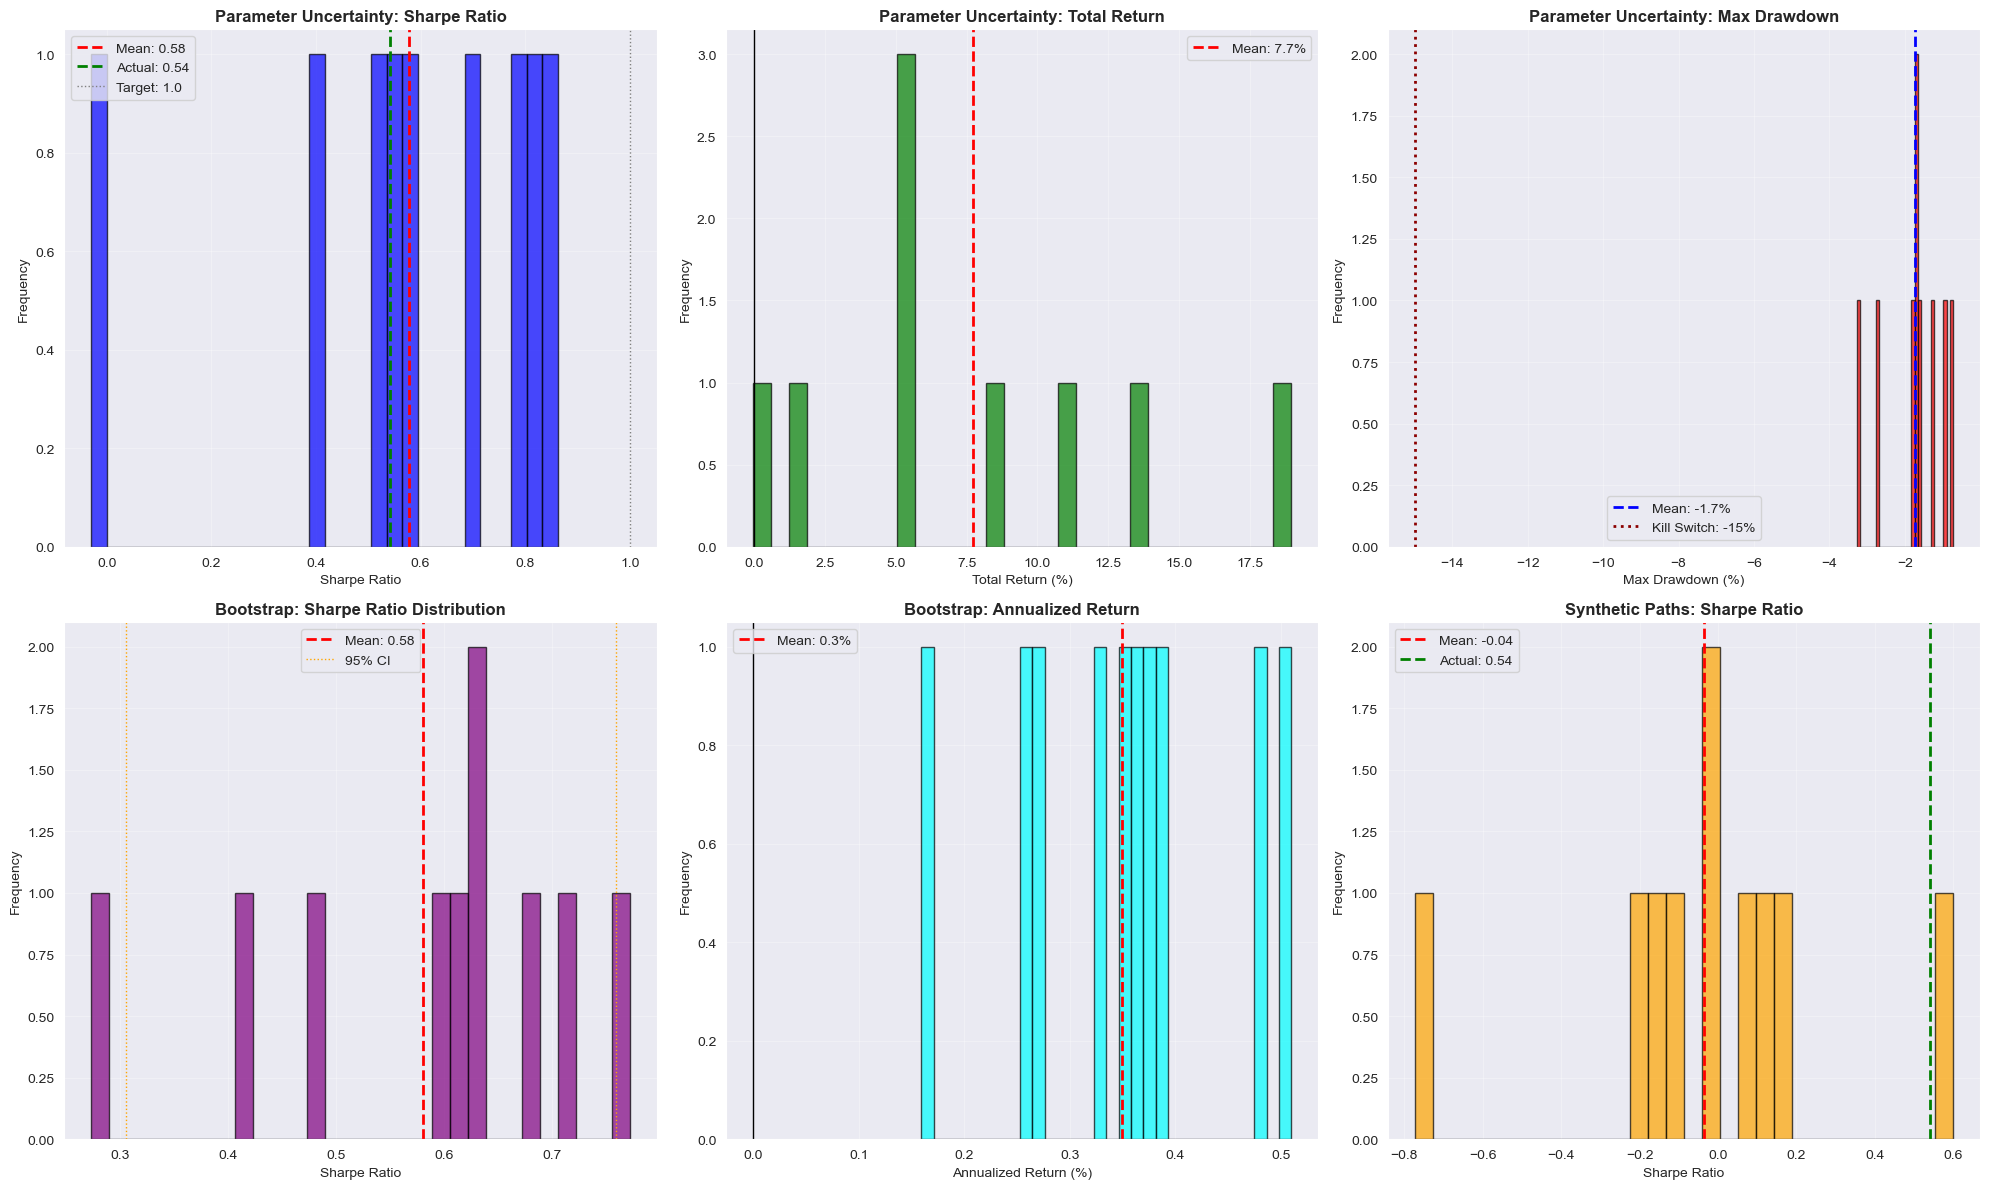


MONTE CARLO SUMMARY

Parameter Uncertainty Test:
  Simulations: 9
  Mean Sharpe: 0.58 ± 0.27
  Sharpe Range: [-0.03, 0.86]
  % Sharpe > Actual (0.54): 66.7%

Bootstrap Resampling:
  Samples: 10
  Mean Return: 0.35%
  95% CI: [0.18%, 0.50%]
  P(Return > 0): 100.0%

Synthetic Price Paths:
  Paths: 10
  Mean Sharpe: -0.04
  % Profitable: 40.0%
  Strategy works on random data: ❌ NO


✅ Visualizations complete!

QUICK MONTE CARLO RESULTS

Parameter Test (n=9):
  Mean Sharpe: 0.58
  Range: [-0.03, 0.86]
  % Profitable: 89%

Bootstrap Test (n=10):
  Mean Return: 0.3%
  Sharpe Range: [0.27, 0.77]

Synthetic Test (n=10):
  Mean Sharpe: -0.04
  % Profitable: 40%




In [24]:
# ============================================================================
# QUICK MONTE CARLO ANALYSIS (10 SIMULATIONS FOR TESTING)
# ============================================================================

# Step 1: Verify results exist
if 'results' not in locals() and 'results' not in globals():
    raise ValueError("❌ Please run the backtest first: results = run_backtest(...)")

# Step 2: Extract required variables
try:
    config = results['config']
    backtester = results['backtester']
    stock_data = backtester.stock_data
    strategy_metrics = results['metrics']
    
    print("✅ All variables extracted successfully")
    print(f"   Config: {type(config)}")
    print(f"   Stock data: {len(stock_data)} stocks")
    print(f"   Strategy Sharpe: {strategy_metrics['sharpe_ratio']:.2f}")
    
except KeyError as e:
    raise ValueError(f"❌ Missing key in results: {e}")

# Step 3: Run Monte Carlo Tests with SMALL sample sizes
print(f"\n{'='*60}")
print("STARTING QUICK MONTE CARLO ANALYSIS (10 simulations each)")
print(f"{'='*60}\n")

# Test 1: Parameter Uncertainty (10 runs)
try:
    print("Test 1/3: Parameter Uncertainty (10 simulations)...")
    param_results = monte_carlo_parameter_test(
        stock_data=stock_data,
        base_config=config,
        n_simulations=10  # ← Changed from 500 to 10
    )
    print(f"✅ Parameter test complete: {len(param_results)} successful runs")
except Exception as e:
    print(f"❌ Parameter test failed: {e}")
    param_results = pd.DataFrame()

# Test 2: Bootstrap Resampling (10 samples)
try:
    print("\nTest 2/3: Bootstrap Resampling (10 samples)...")
    bootstrap_results = monte_carlo_bootstrap_test(
        strategy_results=strategy_metrics['daily_data'],
        n_samples=10  # ← Changed from 1000 to 10
    )
    print(f"✅ Bootstrap test complete: {len(bootstrap_results)} samples")
except Exception as e:
    print(f"❌ Bootstrap test failed: {e}")
    bootstrap_results = pd.DataFrame()

# Test 3: Synthetic Paths (10 paths)
try:
    print("\nTest 3/3: Synthetic Price Paths (10 paths)...")
    synthetic_results = monte_carlo_synthetic_paths(
        stock_list=stock_list[:5],  # ← Use only 5 stocks for speed
        start_date=start_date,
        end_date=end_date,
        base_config=config,
        n_paths=10  # ← Changed from 100 to 10
    )
    print(f"✅ Synthetic test complete: {len(synthetic_results)} paths")
except Exception as e:
    print(f"❌ Synthetic test failed: {e}")
    synthetic_results = pd.DataFrame()

# Step 4: Visualize Results
if len(param_results) > 0 or len(bootstrap_results) > 0 or len(synthetic_results) > 0:
    print("\nGenerating visualizations...")
    plot_monte_carlo_results(
        param_results=param_results,
        bootstrap_results=bootstrap_results,
        synthetic_results=synthetic_results,
        actual_sharpe=strategy_metrics['sharpe_ratio']
    )
    print("✅ Visualizations complete!")
else:
    print("⚠️ No results to visualize")

# Print quick summary
print(f"\n{'='*60}")
print("QUICK MONTE CARLO RESULTS")
print(f"{'='*60}")

if len(param_results) > 0:
    print(f"\nParameter Test (n={len(param_results)}):")
    print(f"  Mean Sharpe: {param_results['sharpe_ratio'].mean():.2f}")
    print(f"  Range: [{param_results['sharpe_ratio'].min():.2f}, {param_results['sharpe_ratio'].max():.2f}]")
    print(f"  % Profitable: {(param_results['total_return'] > 0).sum() / len(param_results) * 100:.0f}%")

if len(bootstrap_results) > 0:
    print(f"\nBootstrap Test (n={len(bootstrap_results)}):")
    print(f"  Mean Return: {bootstrap_results['annualized_return'].mean()*100:.1f}%")
    print(f"  Sharpe Range: [{bootstrap_results['sharpe_ratio'].min():.2f}, {bootstrap_results['sharpe_ratio'].max():.2f}]")

if len(synthetic_results) > 0:
    print(f"\nSynthetic Test (n={len(synthetic_results)}):")
    print(f"  Mean Sharpe: {synthetic_results['sharpe_ratio'].mean():.2f}")
    print(f"  % Profitable: {(synthetic_results['total_return'] > 0).sum() / len(synthetic_results) * 100:.0f}%")

print(f"\n{'='*60}\n")